In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
!kaggle datasets download -d aayush9753/image-colorization-dataset

 97% 458M/473M [00:03<00:00, 142MB/s]
100% 473M/473M [00:04<00:00, 122MB/s]


In [4]:
!unzip -qq /content/image-colorization-dataset.zip

In [5]:
# Feature (input awal) --> black
# Target (output akhir) --> color

# Data training --> split 20% validation
# Feauture --> train_black
# Target --> train_color

# Data testing
# Feature --> test_black
# Target --> test_color

In [6]:
# Pipeline Dataset
# 1. Buka file gambar, sebagai matrix 3D
# 2. Resize jadi ukuran tertentu
# 3. Normalisasi dari 0-255 jadi 0-1
# 4. Menentukan batch

import tensorflow as tf
from sklearn.model_selection import train_test_split
from glob import glob

train_black_paths = glob('/content/data/train_black/*jpg') # feature x
train_color_paths = glob('/content/data/train_color/*jpg') # target y

# split training & validation
x_train, x_val, y_train, y_val = train_test_split(train_black_paths, train_color_paths, test_size=0.2, random_state=42)

print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))


TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
SHUFFLE_BUFFER = 128
PREFETCH = tf.data.AUTOTUNE


@tf.function
def parse_function(x_path, y_path):

  x_file = tf.io.read_file(x_path)
  y_file = tf.io.read_file(y_path)

  x_image = tf.image.decode_jpeg(x_file, channels=3)
  x_image = tf.image.convert_image_dtype(x_image, dtype=tf.float32)
  x_image = tf.image.resize(x_image, TARGET_SIZE)

  y_image = tf.image.decode_jpeg(y_file, channels=3)
  y_image = tf.image.convert_image_dtype(y_image, dtype=tf.float32)
  y_image = tf.image.resize(y_image, TARGET_SIZE)
  
  return x_image, y_image


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(parse_function).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(PREFETCH)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(PREFETCH)

4000
1000
4000
1000


In [7]:
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(*TARGET_SIZE, 3))
x = layers.Conv2D(3, 3, activation='relu', padding='same')(inputs)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
outputs = layers.Conv2D(3, 3, activation='relu', padding='same')(x)

model = models.Model(inputs, outputs)
model.summary()

def psnr(pred, gt):
  return tf.image.psnr(pred, gt, max_val=1.0)

def ssim(pred, gt):
  return tf.image.ssim(pred, gt, max_val=1.0)

model.compile(loss='mse', optimizer='adam', metrics=[psnr, ssim])

model.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    epochs=5
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 3)       435       
                                                                 
Total params: 967
Trainable params: 967
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 [==============================] - 36s 85ms/step - loss: 0.0189 - psnr: 20.0857 - ssim: 0.7789 - val_loss: 0.0093 - val_psnr: 21.9032 - val_ssim: 0.8678
Epoch 2/5
250/250 [=====

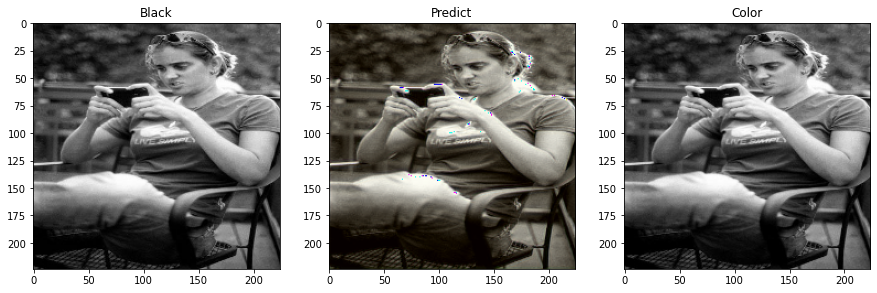

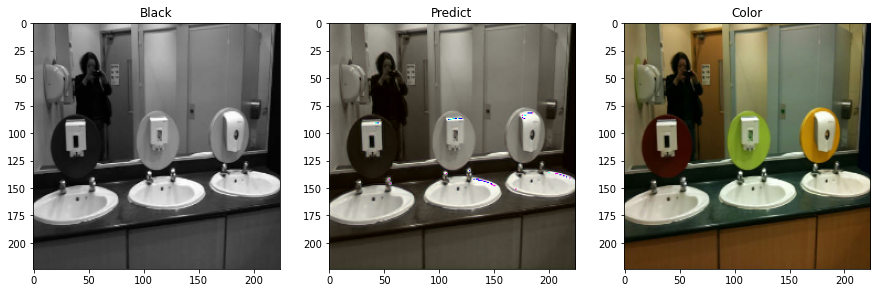

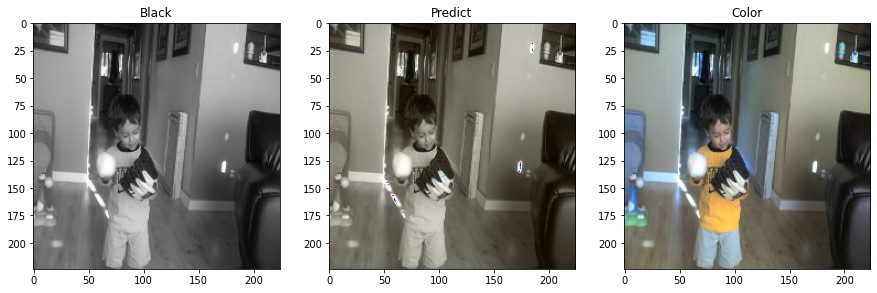

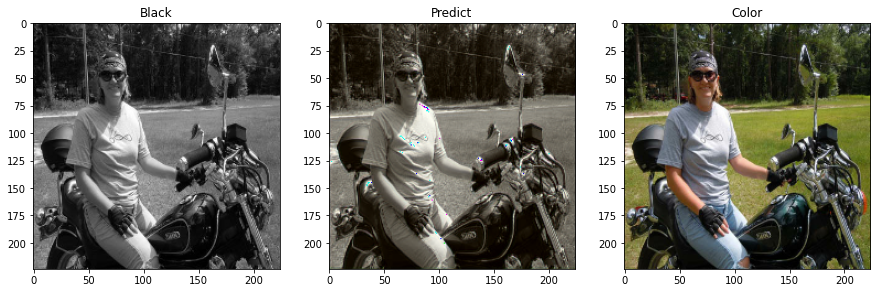

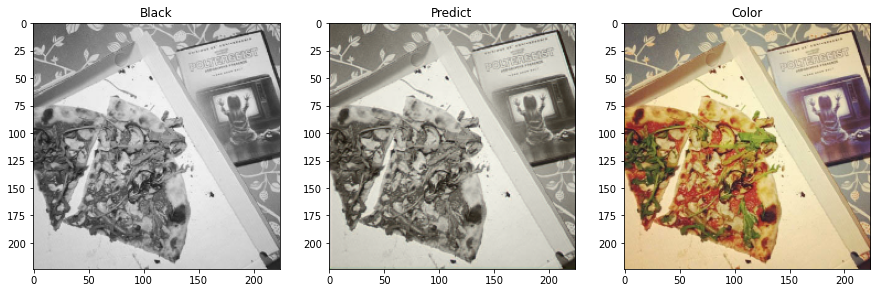

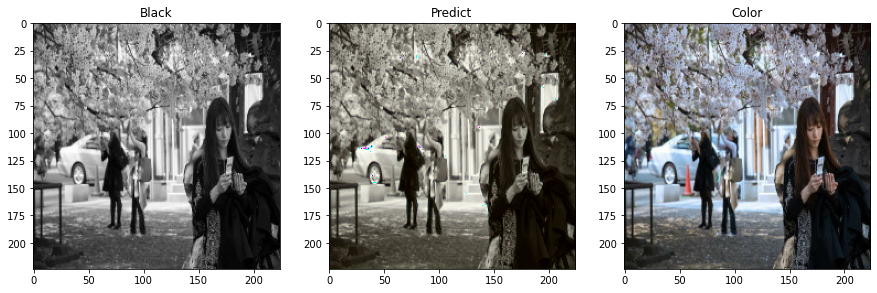

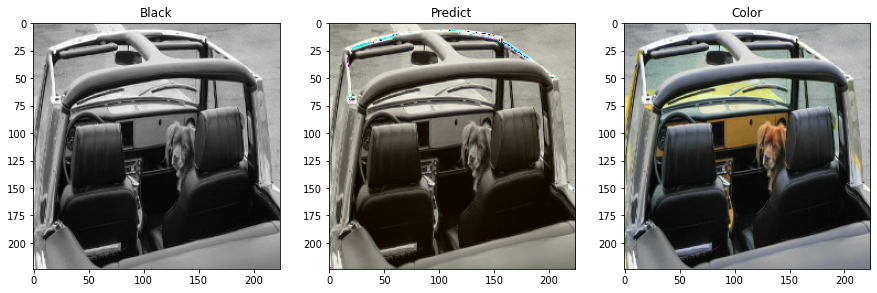

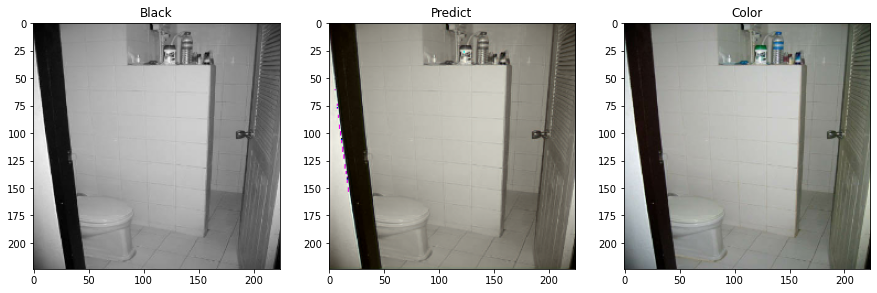

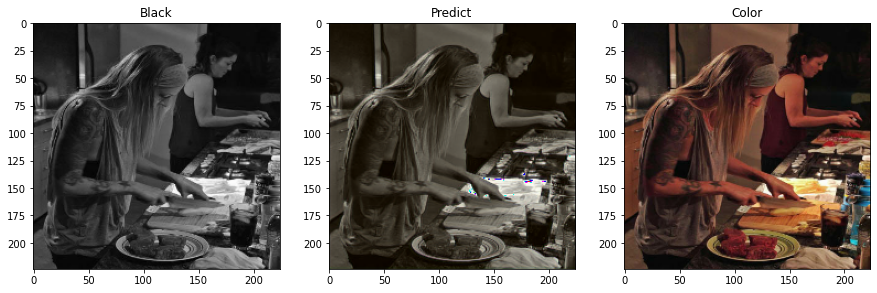

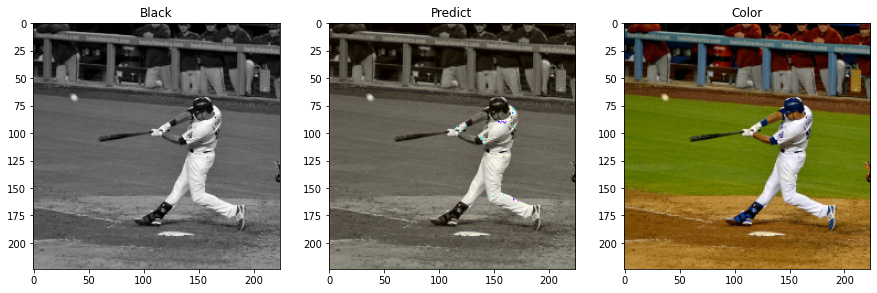

In [13]:
import numpy as np
import matplotlib.pyplot as plt

test_black = glob('/content/data/test_black/*jpg')
test_color = glob('/content/data/test_color/*jpg')

for black, color in zip(test_black[:10], test_color[:10]):
  x, y = parse_function(black, color)
  pred = model(np.expand_dims(x, axis=0))
  y_hat = np.squeeze(pred, axis=0)
  y_hat = (y_hat * 255).astype(np.uint8)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title('Black')
  plt.imshow(x)
  plt.subplot(1, 3, 2)
  plt.title('Predict')
  plt.imshow(y_hat)
  plt.subplot(1, 3, 3)
  plt.title('Color')
  plt.imshow(y)
  plt.show()